In [1]:
files = [
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\raise eybrows quick + garbage_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\raise eyebrows and hold_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\reading outloud-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\smiling-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\squinting-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\blinks_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\eye gaze left right 1_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\eye gaze left right 2_labeled_af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\eye movements up down-labeled-af.csv",
    r"C:\Users\user\OneDrive - post.bgu.ac.il\פרויקט Blinkaid\data from subject1 - Yonathan\tagged_data\after_format\noise-labeled-af.csv"
]

In [3]:
import pandas as pd

def load_and_concatenate_csv(file_list):
    """
    Loads multiple CSV files and concatenates them into a single DataFrame.
    
    Parameters:
    file_list (list of str): List of CSV file paths.
    
    Returns:
    pd.DataFrame: Concatenated DataFrame with all data from the files.
    """
    df_list = []
    
    for file in file_list:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    if df_list:
        return pd.concat(df_list, ignore_index=True)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no files were loaded
    
combined_df = load_and_concatenate_csv(files)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
combined_df = combined_df.drop(columns=['timestamp'])
# Ensure 'label' column is a string type to avoid comparison issues
combined_df['label'] = combined_df['label'].astype(str)

# Define the new label mapping
class_mapping = {
    "i-2up": 0,
    "i-2down": 1,
    "i-left2center": 2,
    "i-center2left": 3,
    "i-right2center": 4,
    "i-center2right": 5
}

# Apply the relabeling function based on the new mapping
combined_df['label'] = combined_df['label'].apply(lambda x: class_mapping.get(x.lower(), 6))

In [5]:
# Count total rows (samples)
total_samples = len(combined_df)

# Count the number of occurrences per class
class_counts = combined_df['label'].value_counts().to_dict()

# Calculate percentage of each class
class_percentages = {label: (count / total_samples) * 100 for label, count in class_counts.items()}

# Print class distribution
for label, percentage in class_percentages.items():
    class_name = next((key for key, value in class_mapping.items() if value == label), f"Unknown ({label})")
    print(f"Percentage of {class_name} in the dataset: {percentage:.2f}%")


Percentage of Unknown (6) in the dataset: 93.80%
Percentage of i-2up in the dataset: 2.22%
Percentage of i-2down in the dataset: 2.08%
Percentage of i-center2left in the dataset: 0.51%
Percentage of i-left2center in the dataset: 0.49%
Percentage of i-right2center in the dataset: 0.49%
Percentage of i-center2right in the dataset: 0.41%


In [6]:
import numpy as np

# Compute duration statistics for each class
duration_stats = {}

for class_name, class_label in class_mapping.items():
    class_indices = np.where(combined_df['label'].values == class_label)[0]
    
    if len(class_indices) > 0:
        durations = []
        start = class_indices[0]
        
        for i in range(1, len(class_indices)):
            if class_indices[i] != class_indices[i - 1] + 1:  # If not consecutive
                durations.append(class_indices[i - 1] - start + 1)
                start = class_indices[i]  # Start a new event
        
        durations.append(class_indices[-1] - start + 1)  # Add last detected duration
        
        # Compute average duration and standard deviation
        avg_duration = np.mean(durations)
        std_duration = np.std(durations)
        
        duration_stats[class_name] = (avg_duration, std_duration)
    else:
        duration_stats[class_name] = (0, 0)  # No instances found

# Print statistics
for class_name, (avg_duration, std_duration) in duration_stats.items():
    print(f"Class: {class_name} | Average Duration: {avg_duration:.2f} samples | Std Dev: {std_duration:.2f} samples")


Class: i-2up | Average Duration: 142.96 samples | Std Dev: 51.56 samples
Class: i-2down | Average Duration: 152.93 samples | Std Dev: 58.09 samples
Class: i-left2center | Average Duration: 78.05 samples | Std Dev: 20.51 samples
Class: i-center2left | Average Duration: 79.95 samples | Std Dev: 16.18 samples
Class: i-right2center | Average Duration: 80.68 samples | Std Dev: 16.83 samples
Class: i-center2right | Average Duration: 81.12 samples | Std Dev: 20.62 samples


In [7]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

# Parameters
num_channels = 16
window_size = 80
step_size = 30
threshold = 0.8  # 70% majority threshold

eyes_files = [
    "eye gaze left right 1_labeled_af.csv",
    "eye gaze left right 2_labeled_af.csv",
    "eye movements up down-labeled-af.csv"
]

def create_windows(emg_data, labels, window_size, step_size, threshold):
    """Generates overlapping windows from EMG data and assigns labels based on majority."""
    
    X, y, indices = [], [], []
    num_samples = len(emg_data)
    
    for start in range(0, num_samples - window_size, step_size):
        window_data = emg_data[start:start + window_size, :]
        window_labels = labels[start:start + window_size]
        
        unique_labels, counts = np.unique(window_labels, return_counts=True)
        majority_ratio = counts / window_size
        
        if np.max(majority_ratio) >= threshold:
            window_label = unique_labels[np.argmax(counts)]
        else:
            window_label = 6  # Undefined label
        
        X.append(window_data)
        y.append(window_label)
        indices.append(start)

    
    return np.array(X), np.array(y), np.array(indices)

train_data, val_data, test_data = [], [], []
train_labels, val_labels, test_labels = [], [], []

for file in files:
    df = pd.read_csv(file)
    df['label'] = df['label'].map(class_mapping).fillna(6)
    df = df.drop(columns=['timestamp'])

    emg_data = df.iloc[:, :-1].values
    labels = df['label'].values

    X_windows, y_windows, window_indices = create_windows(emg_data, labels, window_size, step_size, threshold)
    
    class_indices = {label: np.where(y_windows == label)[0] for label in np.unique(y_windows) if label != 6}
    remains = np.where(y_windows == 6)[0].tolist()
    
    for label, indices in class_indices.items():
        if len(indices) > 0:
            train_end_idx = indices[int(0.6 * len(indices))] + 4 if len(indices) > int(0.6 * len(indices)) else indices[-1]
            val_end_idx = indices[int(0.8 * len(indices))] + 4 if len(indices) > int(0.8 * len(indices)) else indices[-1]
            
            for i in indices:
                if i <= train_end_idx:
                    train_data.append(X_windows[i])
                    train_labels.append(y_windows[i])
                    if i in remains:
                        remains.remove(i)
                elif i <= val_end_idx:
                    val_data.append(X_windows[i])
                    val_labels.append(y_windows[i])
                    if i in remains:
                        remains.remove(i)
                else:
                    test_data.append(X_windows[i])
                    test_labels.append(y_windows[i])
                    if i in remains:
                        remains.remove(i)
    
    np.random.shuffle(remains)
    num_train = int(0.6*len(remains)) 
    num_val = int(0.2*len(remains))
    
    train_data.extend([X_windows[i] for i in remains[:num_train]])
    train_labels.extend([y_windows[i] for i in remains[:num_train]])
    val_data.extend([X_windows[i] for i in remains[num_train:num_train + num_val]])
    val_labels.extend([y_windows[i] for i in remains[num_train:num_train + num_val]])
    test_data.extend([X_windows[i] for i in remains[num_train + num_val:]])
    test_labels.extend([y_windows[i] for i in remains[num_train + num_val:]])

# Convert lists to numpy arrays
X_train, y_train = np.array(train_data), np.array(train_labels)
X_val, y_val = np.array(val_data), np.array(val_labels)
X_test, y_test = np.array(test_data), np.array(test_labels)

print(f"Final Windows: Train ({len(X_train)}), Validation ({len(X_val)}), Test ({len(X_test)})")


Final Windows: Train (6307), Validation (2099), Test (2094)


In [8]:
from imblearn.over_sampling import RandomOverSampler

# Oversample only X_train, NOT X_val or X_test
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train.reshape(len(X_train), -1), y_train)

# Reshape back to original dimensions
X_train_resampled = X_train_resampled.reshape(-1, 80, 16)


In [10]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

# Parameters
num_channels = 16
image_height = 100
min_val, max_val = -60, 60
num_classes = 7  # Adjusted for classes 0 to 6


# Convert EMG signals to images
def normalize_and_convert_to_image(signal):
    """ Converts EMG window to an image of size (25, 150). """
    normalized_signal = (signal - min_val) / (max_val - min_val)
    normalized_signal = np.clip(normalized_signal, 0, 1)
    image = np.zeros((image_height, window_size))
    for t in range(window_size):
        pixel_y = int(normalized_signal[t] * (image_height - 1))
        image[pixel_y, t] = 1
    return image

# Convert each window to an image for each channel
X_train_images = np.zeros((len(X_train_resampled), num_channels, image_height, window_size, 1), dtype=np.float32)
X_val_images = np.zeros((len(X_val), num_channels, image_height, window_size, 1), dtype=np.float32)
X_test_images = np.zeros((len(X_test), num_channels, image_height, window_size, 1), dtype=np.float32)

for i in range(len(X_train)):
    for ch in range(num_channels):
        X_train_images[i, ch, :, :, 0] = normalize_and_convert_to_image(X_train[i, :, ch])

for i in range(len(X_val)):
    for ch in range(num_channels):
        X_val_images[i, ch, :, :, 0] = normalize_and_convert_to_image(X_val[i, :, ch])

for i in range(len(X_test)):
    for ch in range(num_channels):
        X_test_images[i, ch, :, :, 0] = normalize_and_convert_to_image(X_test[i, :, ch])


# Rebuild input lists to match the new sample size
X_train_list = [X_train_images[:, ch, :, :, :] for ch in range(num_channels)]
X_val_list = [X_val_images[:, ch, :, :, :] for ch in range(num_channels)]
X_test_list = [X_test_images[:, ch, :, :, :] for ch in range(num_channels)]

# Compute class weights including class 6
all_classes = np.arange(num_classes)  # Ensure all classes from 0 to num_classes-1 are included
class_weights = compute_class_weight(class_weight="balanced", classes=all_classes, y=y_train_resampled)
class_weight_dict = {int(cls): weight for cls, weight in zip(all_classes, class_weights)}

print(f"class_weight_dict:{class_weight_dict}")


class_weight_dict:{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}


In [11]:


# Build Multi-Channel CNN Model
def build_multi_channel_cnn():
    """CNN Model for Multi-Class EMG-Based Classification"""
    input_shape = (image_height, window_size, 1)
    inputs = [keras.Input(shape=input_shape) for _ in range(num_channels)]
    
    conv_blocks = []
    for inp in inputs:
        x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(inp)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Flatten()(x)
        conv_blocks.append(x)
    
    merged = layers.Concatenate()(conv_blocks)
    x = layers.Dense(128, activation="relu")(merged)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Create the model
multi_channel_cnn = build_multi_channel_cnn()
multi_channel_cnn.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                             

 max_pooling2d (MaxPooling2D)   (None, 50, 40, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 50, 40, 16)  0           ['conv2d_2[0][0]']               
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 50, 40, 16)  0           ['conv2d_4[0][0]']               
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 50, 40, 16)  0           ['conv2d_6[0][0]']               
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 50, 40, 16)  0           ['conv2d_8[0][0]']               
                                                                                                  
 max_pooli

 max_pooling2d_9 (MaxPooling2D)  (None, 25, 20, 32)  0           ['conv2d_9[0][0]']               
                                                                                                  
 max_pooling2d_11 (MaxPooling2D  (None, 25, 20, 32)  0           ['conv2d_11[0][0]']              
 )                                                                                                
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 25, 20, 32)  0           ['conv2d_13[0][0]']              
 )                                                                                                
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 25, 20, 32)  0           ['conv2d_15[0][0]']              
 )                                                                                                
          

                                                                                                  
 dense (Dense)                  (None, 128)          32768128    ['concatenate[0][0]']            
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dropout[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 64)           0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 7)            455         ['dropout_1[0][0]']              
          

In [12]:

# Train the CNN with memory-efficient data loading
history = multi_channel_cnn.fit(
    X_train_list, y_train_resampled,
    epochs=2, batch_size=32,
    validation_data=(X_val_list, y_val),
    class_weight=class_weight_dict  # Handles any remaining imbalance
)

Epoch 1/2
1327/1327 [==============================] - 1456s 1s/step - loss: 1.5782 - accuracy: 0.2845 - val_loss: 0.1474 - val_accuracy: 0.9633
Epoch 2/2
1327/1327 [==============================] - 1455s 1s/step - loss: 1.5453 - accuracy: 0.2848 - val_loss: 0.1342 - val_accuracy: 0.9690


66/66 [==============================] - 15s 229ms/step
Validation Set Performance:
              precision    recall  f1-score   support

         0.0     0.6522    0.4545    0.5357        33
         1.0     0.5556    0.5882    0.5714        34
         2.0     0.0000    0.0000    0.0000         4
         3.0     0.0000    0.0000    0.0000         3
         4.0     0.0000    0.0000    0.0000         4
         5.0     1.0000    0.6667    0.8000         3
         6.0     0.9799    0.9896    0.9847      2018

    accuracy                         0.9690      2099
   macro avg     0.4554    0.3856    0.4131      2099
weighted avg     0.9628    0.9690    0.9655      2099



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


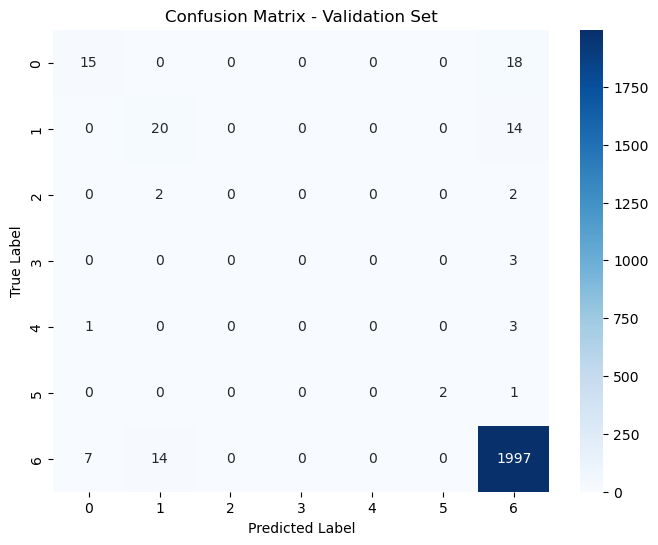

In [13]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get model predictions
y_val_pred = multi_channel_cnn.predict(X_val_list)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels

# Generate classification report
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred_classes, digits=4))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.show()
